# Training a CNN with Keras on the CIFAR 10 dataset

This notebook shows how to continue training a model.



Start with importing the necessary packages

In [3]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D,MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.initializers import Constant
from keras import callbacks

from keras import backend as K
# from cnn.alexnet import alexnet_model

from keras.optimizers import SGD
from keras.datasets import cifar10

import os

import results
import matplotlib.pyplot as plt
import numpy as np

import pickle
from DataLoader import MyDataLoader

#### Input args
continue_training = True
verbose = 1

Using TensorFlow backend.


In [4]:
# Set some custom details

# image details
height = 32
width = 32
depth = 3

classes = 10

output_folder = './results'
model_folder = output_folder + '/models'

In [5]:
# load the training and testing data, scale it into the range [0, 1],
# then reshape the design matrix
print("[INFO] loading CIFAR-10 data...")
(trainX, trainY), (testX, testY), labelNames = MyDataLoader().load_dataset()

# # For initial testing, let's split everything up, to see if things work.
# training_size = 1000
# test_size = 50
#
# trainX = trainX[0:training_size,:]
# trainY = trainY[0:training_size]
# testX = testX[0:test_size,:]
# testY = testY[0:test_size]

print("Training set size X: ", trainX.shape)
print("Training set size Y: ", trainY.shape)


print("Test set size X: ", testX.shape)
print("Test set size Y: ", testY.shape)

[INFO] loading CIFAR-10 data...
Loading training images
[INFO] processed 5000
[INFO] processed 10000
[INFO] processed 15000
[INFO] processed 20000
[INFO] processed 25000
[INFO] processed 30000
[INFO] processed 35000
[INFO] processed 40000
[INFO] processed 45000
[INFO] processed 50000
Loading test images
[INFO] processed 5000
[INFO] processed 10000
Training set size X:  (50000, 32, 32, 3)
Training set size Y:  (50000, 10)
Test set size X:  (10000, 32, 32, 3)
Test set size Y:  (10000, 10)


## Preview data

(32, 32, 3)
[1 0 0 0 0 0 0 0 0 0]
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


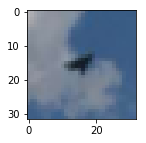

In [6]:
print(trainX[0,].shape)

plt.figure(figsize=(2,2))
plt.imshow(testX[13])
print(testY[13])
print(labelNames)

# Define model

Here we define the Mini Alexnet model as described in [this paper]( https://arxiv.org/abs/1611.03530)

In [ ]:
# Example model
model = models.Sequential()
model.add(KL.Conv2D(96, (5, 5),
                    input_shape=(32, 32, 3),
                    kernel_initializer='glorot_normal',
                    bias_initializer=initializers.Constant(0.1),
                    padding='same',
                    activation='relu'))

model.add(KL.MaxPooling2D((3, 3), padding='valid'))
model.add(KL.BatchNormalization())
model.add(KL.Dropout(rate=0.1))

model.add(KL.Flatten())

model.add(KL.Dense(10, 
                   kernel_initializer='glorot_normal',
                   bias_initializer=initializers.Constant(0.1), 
                   activation='softmax'))

model.summary()

## Training the model

In [ ]:
# Setting hyperparameters
epochs = 10
learning_rate = 0.01
decay = 0
momentum = 1
batch_size= 32

# optimizer
optimizer = SGD(learning_rate)

name = 'CallbackShowCase' 

## Checking if we need/can continue

Based on a property set in the top we will (dis)allow for continuation (property named `continue_training`). 

If that's there, the value will be used as filepath

In [ ]:
print("[INFO] Checking if there's a set of weights that we can use")

filepath = '{}/{}-best.hdf5'.format(model_folder, name) 
# If exists a best model, load its weights!
if continue_training is True and os.path.isfile(filepath):
    print ("Resumed model's weights from {}".format(filepath))
    # load weights
    model.load_weights(filepath)
else:
    print("Nope, starting from scratch")

In [ ]:
%%time
print("[INFO] training network...")

# train the model using SGD
model.compile(loss="categorical_crossentropy", optimizer=optimizer,
                metrics=["accuracy"])


# Keep only a single checkpoint, the best over test accuracy.

checkpoint = callbacks.ModelCheckpoint(filepath,
                            monitor='val_acc',
                            verbose=1,
                            save_best_only=True,
                            mode='max')

earlyStopping = callbacks.EarlyStopping(monitor='val_acc', 
                                        min_delta=.005, 
                                        patience=3, 
                                        verbose=0, 
                                        mode='auto'
                                       )

H = model.fit(trainX, trainY, validation_data=(testX, testY),
                epochs=epochs, batch_size=batch_size, verbose=verbose,
             callbacks=[checkpoint, earlyStopping])


# Saving the network to disk
Now that we have save the model after every Epoch (if result is better), we don't need to save it manually

In [ ]:
# results.save_model(model, H, filename=name)

## Evaluating the model

In [2]:
#Make name unique to save output
date =!date -uI'seconds'
experiment_name = name + '-' + date[0]


# Showing training results
plot = results.plotTrainingLossAndAccuracy(H)

plt.savefig('{}/{}-training.png'.format(model_folder,experiment_name))
plot.show()


# evaluate the network
print("[INFO] evaluating network...")
results.evaluate(model, testX,testY, label_names= labelNames, filename = '{}/{}'.format(output_folder, experiment_name ))


NameError: name 'name' is not defined

## After talk

We have seen four important ingredients to a neural network:

1. Dataset. You need a *representative* set of data on which you can both train and evaluate the model. The data should encompass most generic as well as exotic variation of what you're trying to detect (in case of airplaines and chairs, you want to include non-commercial jets and designer chairs in the set as well for example)
1. Loss function. How do you score how well your model predicted the output, given an input.
1. Model. How does the architecture of your NN look like? It is all fully connected (dense) layers? What activation functions do you use.
  1. How many datapoints do you have (size of 1 input, size of training set)
  1. Number of classes needed for classification
  1. (dis)similarity between classes  (designer chair vs ordinary chair is much more complex than airplane vs cat for example)
  1. The intra class variance (if designer chairs and ordinary chair should be in the same class, this increases difficulty as well
1. Optimization method. The final piece, but rather important. Common ones are: Stochastic Gradient Descent, RMSProp, Adagrad, Adadelte, Adam and more advanced ones. For a first iteration, it is good to start with SGD, find a good learning rate / batch size, and then up it with some regularization and or momentum.






